Part1: Data Preprocessing and EDA

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

In [ ]:
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModel
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import create_optimizer, AdamWeightDecay
from transformers import pipeline
import datasets
from datasets import Dataset, DatasetDict
#from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from rouge import Rouge

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
df = pd.read_csv("news_summary.csv", encoding="latin-1")
df.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  
0  The Daman and Diu administration on Wednesday ...  
1  From her special numbers to TV?appearances, Bo...  
2  The Indira Gandhi Institute of Medical Science...  
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4  Hotels in Mumbai and other Indian cities are t...

In [ ]:
df.describe()

author                   date  \
count           4514                   4514   
unique            45                    240   
top     Chhavi Tyagi  19 Jul 2017,Wednesday   
freq             559                     76   

                                                headlines  \
count                                                4514   
unique                                               4514   
top     More than half of India's languages may die in...   
freq                                                    1   

                                                read_more  \
count                                                4514   
unique                                               4461   
top     http://indiatoday.intoday.in/story/assembly-el...   
freq                                                   13   

                                                     text  \
count                                                4514   
unique                                               4514   
top     At least 400 languages or more than half langu...   
freq                                                    1   

                                                    ctext  
count                                                4396  
unique                                               4341  
top     AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...  
freq                                                   13

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [ ]:
df = df.dropna()
df.describe()

author                   date  \
count           4396                   4396   
unique            45                    240   
top     Chhavi Tyagi  19 Jul 2017,Wednesday   
freq             546                     76   

                                                headlines  \
count                                                4396   
unique                                               4396   
top     More than half of India's languages may die in...   
freq                                                    1   

                                                read_more  \
count                                                4396   
unique                                               4344   
top     http://indiatoday.intoday.in/story/assembly-el...   
freq                                                   13   

                                                     text  \
count                                                4396   
unique                                               4396   
top     At least 400 languages or more than half langu...   
freq                                                    1   

                                                    ctext  
count                                                4396  
unique                                               4341  
top     AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...  
freq                                                   13

In [ ]:
# Converting to lowercase
df['ctext'] = df['ctext'].apply(str.lower)
df['text'] = df['text'].apply(str.lower)
df['headlines'] = df['headlines'].apply(str.lower)
df.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  daman & diu revokes mandatory rakshabandhan in...   
1  malaika slams user who trolled her for 'divorc...   
2  'virgin' now corrected to 'unmarried' in igims...   
3  aaj aapne pakad liya: let man dujana before be...   
4  hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                                text  \
0  the administration of union territory daman an...   
1  malaika arora slammed an instagram user who tr...   
2  the indira gandhi institute of medical science...   
3  lashkar-e-taiba's kashmir commander abu dujana...   
4  hotels in maharashtra will train their staff t...   

                                               ctext  
0  the daman and diu administration on wednesday ...  
1  from her special numbers to tv?appearances, bo...  
2  the indira gandhi institute of medical science...  
3  lashkar-e-taiba's kashmir commander abu dujana...  
4  hotels in mumbai and other indian cities are t...

In [ ]:
df['headlines_length'] = [len(x.split()) for x in df.headlines]
df['text_length'] = [len(x.split()) for x in df.text]
df['ctext_length'] = [len(x.split()) for x in df.ctext]
df.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  headlines_length  \
0  The Daman and Diu administration on Wednesday ...                 9   
1  From her special numbers to TV?appearances, Bo...                10   
2  The Indira Gandhi Institute of Medical Science...                 8   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...                10   
4  Hotels in Mumbai and other Indian cities are t...                11   

   text_length  ctext_length  
0           60           364  
1           60           396  
2           60           335  
3           60           404  
4           60           526

In [ ]:
df = df[df['ctext_length'] >= df['text_length']]
df.describe()

headlines_length  text_length  ctext_length
count       4274.000000  4274.000000   4274.000000
mean           9.300889    58.299719    351.740056
std            1.407168     2.314246    358.884472
min            4.000000    44.000000     50.000000
25%            8.000000    57.000000    193.000000
50%            9.000000    59.000000    288.000000
75%           10.000000    60.000000    416.000000
max           14.000000    62.000000  12202.000000

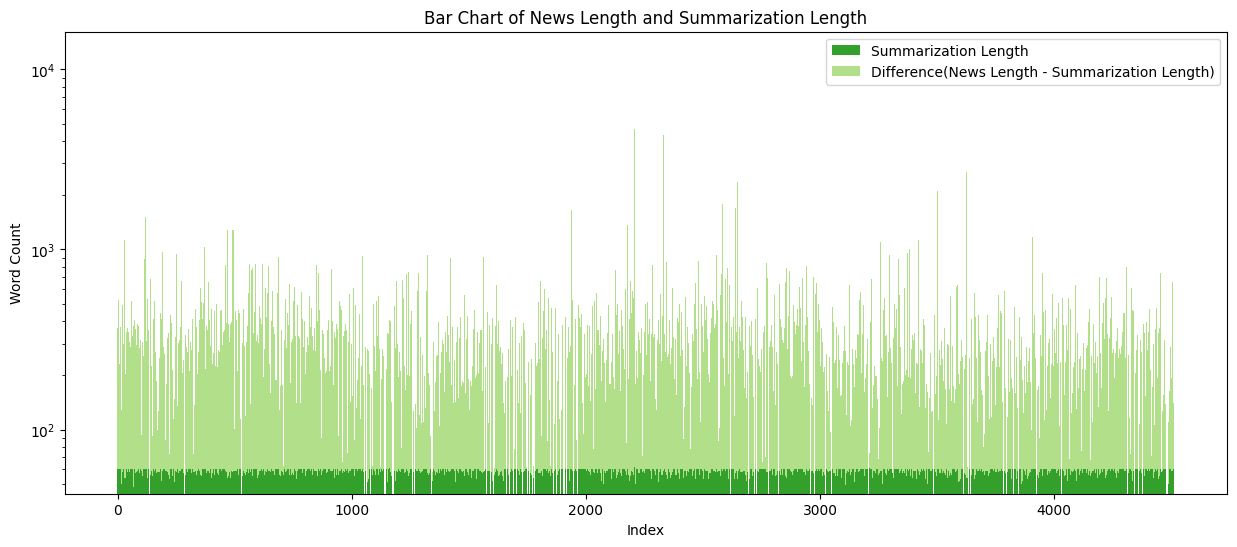

In [ ]:
df['diff'] = df['ctext_length'] - df['text_length']
#sns.set(style="whitegrid")
color1 = sns.color_palette("Paired")[3]
color2 = sns.color_palette("Paired")[2]

plt.figure(figsize=(15, 6))
bar1 = plt.bar(df.index, df['text_length'], color=color1, label='Summarization Length', width=1.0)
bar2 = plt.bar(df.index, df['diff'], bottom=df['text_length'], color=color2, label='Difference(News Length - Summarization Length)', width=1.0)

plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Bar Chart of News Length and Summarization Length')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
df = df.drop(columns=['headlines_length', 'text_length', 'ctext_length', 'diff'])
df.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  
0  The Daman and Diu administration on Wednesday ...  
1  From her special numbers to TV?appearances, Bo...  
2  The Indira Gandhi Institute of Medical Science...  
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4  Hotels in Mumbai and other Indian cities are t...

In [ ]:
df['news'] = df['headlines'] + '. ' + df['ctext']
df.rename(columns={"text": "summary"}, inplace = True)
df = df.drop(columns=['headlines', 'ctext'])
df.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                             summary  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                                news  
0  Daman & Diu revokes mandatory Rakshabandhan in...  
1  Malaika slams user who trolled her for 'divorc...  
2  'Virgin' now corrected to 'Unmarried' in IGIMS...  
3  Aaj aapne pakad liya: LeT man Dujana before be...  
4  Hotel staff to get training to spot signs of s...

In [ ]:
# Making the dataset
prefix = 'summarize: '
df['news'] = prefix + df['news']
df.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                             summary  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                                news  
0  summarize: Daman & Diu revokes mandatory Raksh...  
1  summarize: Malaika slams user who trolled her ...  
2  summarize: 'Virgin' now corrected to 'Unmarrie...  
3  summarize: Aaj aapne pakad liya: LeT man Dujan...  
4  summarize: Hotel staff to get training to spot...

In [ ]:
# Converting the pandas dataset to huggingface dataset
# first split the train and test set
train_df, test_df = train_test_split(df, test_size=0.01, shuffle=True)
print("train and val shape:", train_df.shape, "test shape:",test_df.shape)
# save for every model inference
global_train_df = train_df
global_test_df = test_df
train_df = datasets.Dataset.from_pandas(train_df)
train_df = train_df.remove_columns(["__index_level_0__"])
# split train into train and val
train_df = train_df.train_test_split(test_size=0.2, shuffle=True) # split train and test
train_df["train"][0]

train and val shape: (4231, 5) test shape: (43, 5)


{'author': 'Aarushi Maheshwari',
 'date': '26 Jul 2017,Wednesday',
 'read_more': 'https://www.theguardian.com/us-news/2017/jul/26/us-energy-secretary-rick-perry-call-ukrainian-pm-pig-manure-prank?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle ',
 'summary': 'Russian pranksters fooled US Energy Secretary Rick Perry into believing he was discussing American coal exports and pig manure with Ukrainian PM Volodymyr Groysman. The pranksters convinced Perry that Ukrainian President Petro Poroshenko had invented a new biofuel made using pig manure and home-brewed alcohol. Perry called the idea "interesting," saying he looked forward to meeting Poroshenko. ',
 'news': 'summarize: Russian pranksters dupe US official to talk about pig manure. The US energy secretary Rick Perry has become the latest victim of a pair of Russian phone pranksters who have previously fooled Elton John into thinking he was chatting to Vladimir Putin.On this occasion, Perry believed he was discussing A

In [ ]:
# Fitting into dataset dict
train_val_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_val_test_dataset))
train_val_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['author', 'date', 'read_more', 'summary', 'news'],
        num_rows: 3384
    })
    val: Dataset({
        features: ['author', 'date', 'read_more', 'summary', 'news'],
        num_rows: 847
    })
})

T5 Fine-tuning

In [ ]:
# tokenize the data
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

In [ ]:
tokenized_data["train"]

Dataset({
    features: ['author', 'date', 'read_more', 'summary', 'news', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3384
})

In [ ]:
# Padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = Rouge().get_scores(decoded_preds, decoded_labels, avg=True, ignore_empty=True)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    # result["gen_len"] = np.mean(prediction_lens)

    return result

In [ ]:
# prepare the model
T5model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [ ]:

#!pip install --upgrade transformers torch
!pip install torchaudio==2.3.1 torchvision==0.18.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.3.0+cu121
    Uninstalling torchaudio-2.3.0+cu121:
      Successfully uninstalled torchaudio-2.3.0+cu121


In [ ]:
# set up hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="t5-news",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)


In [ ]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = T5model,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

TrainOutput(global_step=1692, training_loss=1.4874611712516623, metrics={'train_runtime': 1579.3283, 'train_samples_per_second': 8.571, 'train_steps_per_second': 1.071, 'total_flos': 8232596872151040.0, 'train_loss': 1.4874611712516623, 'epoch': 4.0})

In [ ]:
# save the model
model_path = "t5-news"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('t5-news/tokenizer_config.json',
 't5-news/special_tokens_map.json',
 't5-news/spiece.model',
 't5-news/added_tokens.json',
 't5-news/tokenizer.json')

T5 Inference
Try the fine-tuned T5 model for our news test set!

In [ ]:
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained("t5-news")

In [ ]:
#for i in range(len(test_df['news']):
for i in range(5):
    print("original_news: ",test_df['news'].iloc[i])
    summarizer = pipeline("summarization", model = model,tokenizer = tokenizer, max_length = 100)
    summary = summarizer(test_df['news'].iloc[i])
    print(summary[0])
    print()

original_news:  summarize: Sanjay apologises for bodyguards assaulting media persons. Sanjay Dutt, who is in Agra shooting for his comeback film Bhoomi, has run into trouble with the law again. The actor's bodyguards roughed up some local mediapersons on Thursday, who filed a police complaint. Reportedly, Sanjay was present when the attack took place, but left the spot. However, he has since issued an apology to the mediapersons.Earlier this week, the shooting of Sanjay's film was stalled when crowds which had gathered to get a glimpse of the actor went out of control.
{'summary_text': 'Actor Sanjay Dutt, who is in Agra shooting for his comeback film Bhoomi, has apologised for his bodyguards assaulting local media persons. Reportedly, he was present when the attack took place, but left the spot.'}

original_news:  summarize: Tharoor 'categorically' denies reports of him joining BJP. Congress MP and former Union Minister Shashi Tharoor denied reports that he was joining the BJP.In a Fac